Models directory exists: True
Checkpoint path writable: True
Using device: cuda
Running feature space analysis first...
Starting feature space analysis...
Extracting features for 1000 videos at resolution=112...


100%|██████████| 1000/1000 [00:01<00:00, 684.19it/s]
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\abhis\Downloads\Documents\Learner Engagement Project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Feature analysis complete! Check 'C:\Users\abhis\Downloads\Documents\Learner Engagement Project\visualizations' for UMAP scatter plots.
Feature space analysis complete. Check 'visualizations' folder if created.
Do you want to proceed with FAME framework? [y/n]
Loading best hyperparameters from C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\effnet123_tcn_best_hyperparams.json
Loading existing final model from C:\Users\abhis\Downloads\Documents\Learner Engagement Project\models\effnet123_fame_final.pth
Model loaded successfully.

Final evaluation on test set...
Looking for test LMDB in directory: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\cache
Found files matching 'Test': [WindowsPath('C:/Users/abhis/Downloads/Documents/Learner Engagement Project/cache/lmdb_flow_TestLabels_112'), WindowsPath('C:/Users/abhis/Downloads/Documents/Learner Engagement Project/cache/lmdb_flow_TestLabels_224'), WindowsPath('C:/Users/abhis/Downloads/Documents/Learner Enga

Evaluating: 100%|██████████| 103/103 [00:04<00:00, 24.89it/s]



Post-processing Engagement...

Post-processing Boredom...

Post-processing Confusion...

Post-processing Frustration...

Evaluating Engagement...

Engagement Classification Report:
              precision    recall  f1-score   support

           0      0.004     0.750     0.008         4
           1      0.050     0.531     0.091        81
           2      0.500     0.005     0.009       849
           3      0.286     0.014     0.027       704

    accuracy                          0.037      1638
   macro avg      0.210     0.325     0.034      1638
weighted avg      0.384     0.037     0.021      1638

Saved confusion matrix to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Engagement_confusion_matrix.png


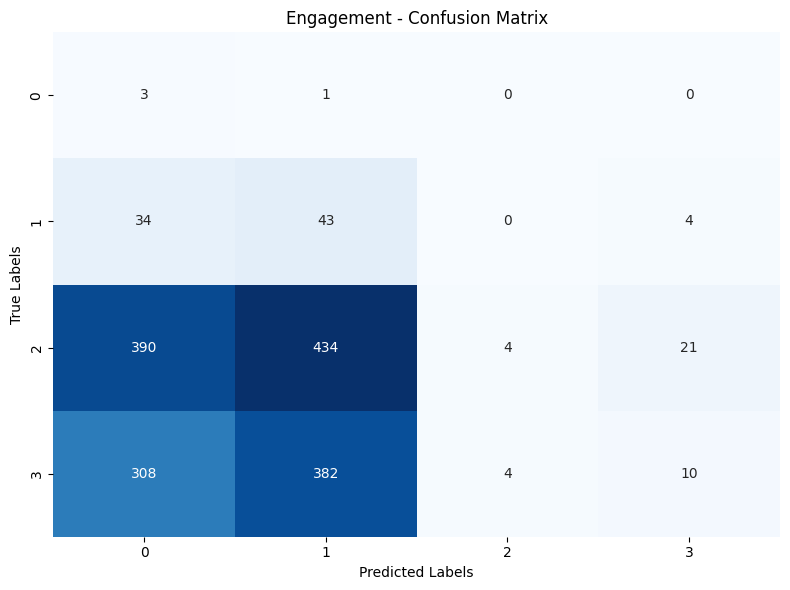

Saved distribution plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Engagement_distribution.png


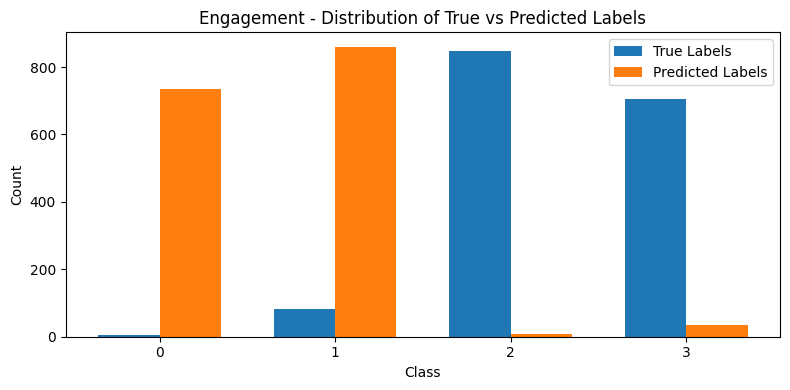

Saved F1 score plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Engagement_f1_scores.png


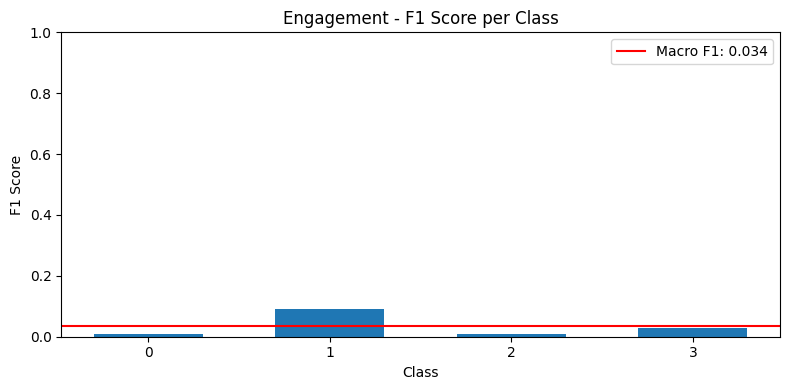


Evaluating Boredom...

Boredom Classification Report:
              precision    recall  f1-score   support

           0      0.250     0.003     0.005       747
           1      0.324     0.324     0.324       519
           2      0.147     0.146     0.146       335
           3      0.019     0.405     0.037        37

    accuracy                          0.143      1638
   macro avg      0.185     0.220     0.128      1638
weighted avg      0.247     0.143     0.136      1638

Saved confusion matrix to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Boredom_confusion_matrix.png


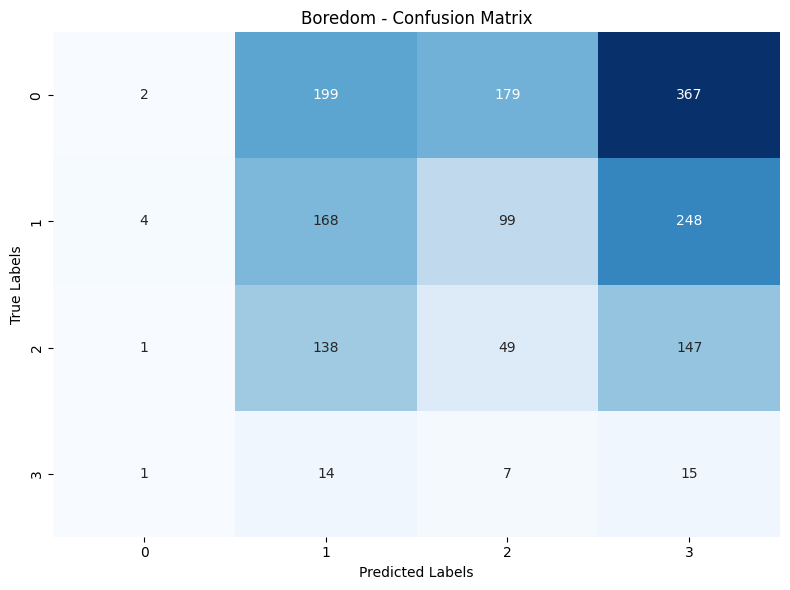

Saved distribution plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Boredom_distribution.png


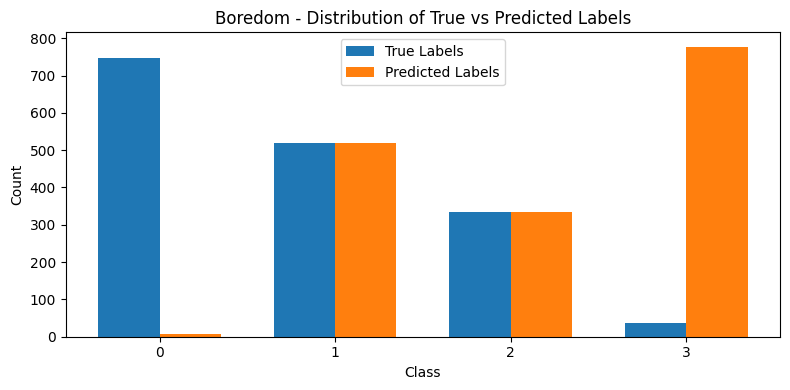

Saved F1 score plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Boredom_f1_scores.png


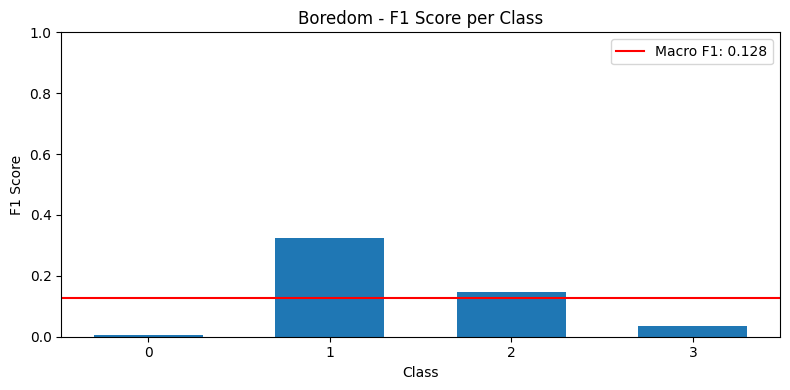


Evaluating Confusion...

Confusion Classification Report:
              precision    recall  f1-score   support

           0      0.692     0.692     0.692      1135
           1      0.215     0.215     0.215       368
           2      0.078     0.078     0.078       116
           3      0.000     0.000     0.000        19

    accuracy                          0.533      1638
   macro avg      0.246     0.246     0.246      1638
weighted avg      0.533     0.533     0.533      1638

Saved confusion matrix to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Confusion_confusion_matrix.png


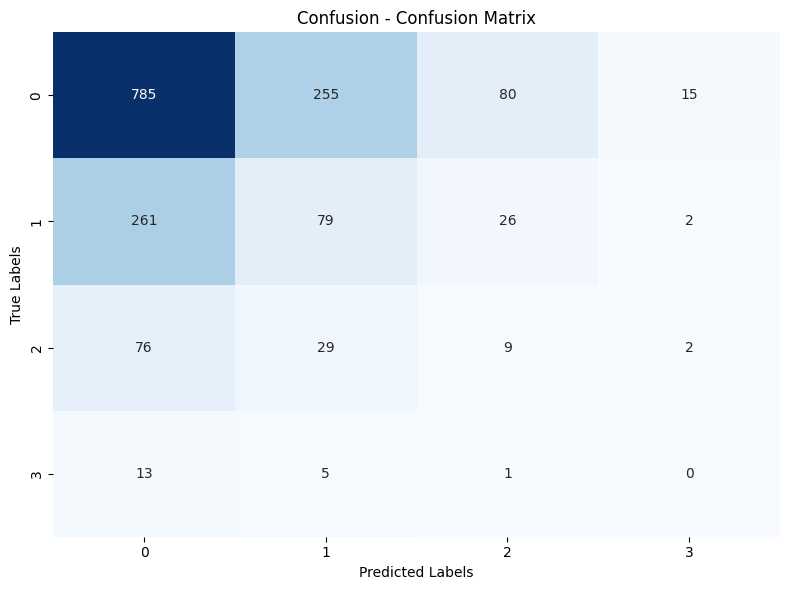

Saved distribution plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Confusion_distribution.png


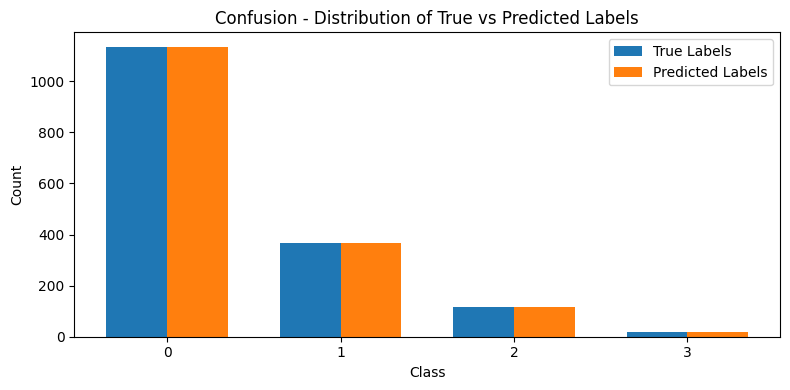

Saved F1 score plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Confusion_f1_scores.png


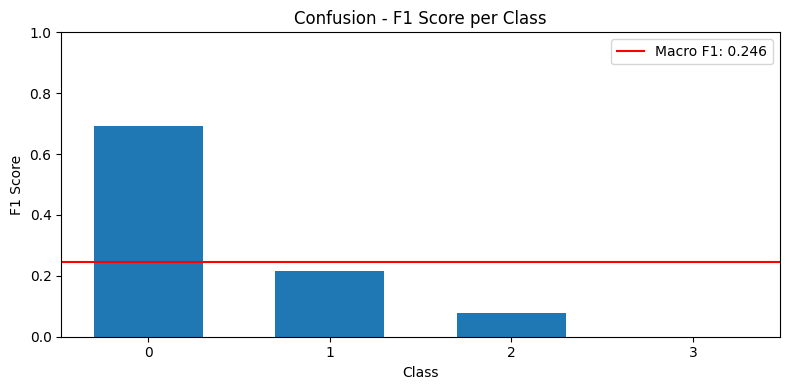


Evaluating Frustration...

Frustration Classification Report:
              precision    recall  f1-score   support

           0      0.773     0.773     0.773      1279
           1      0.175     0.175     0.175       280
           2      0.055     0.054     0.054        56
           3      0.000     0.000     0.000        23

    accuracy                          0.636      1638
   macro avg      0.251     0.250     0.251      1638
weighted avg      0.636     0.636     0.636      1638

Saved confusion matrix to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Frustration_confusion_matrix.png


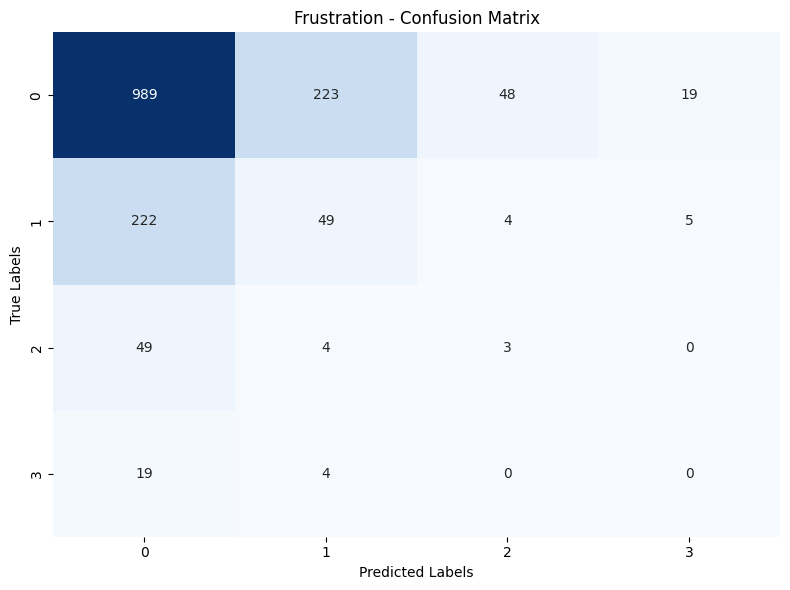

Saved distribution plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Frustration_distribution.png


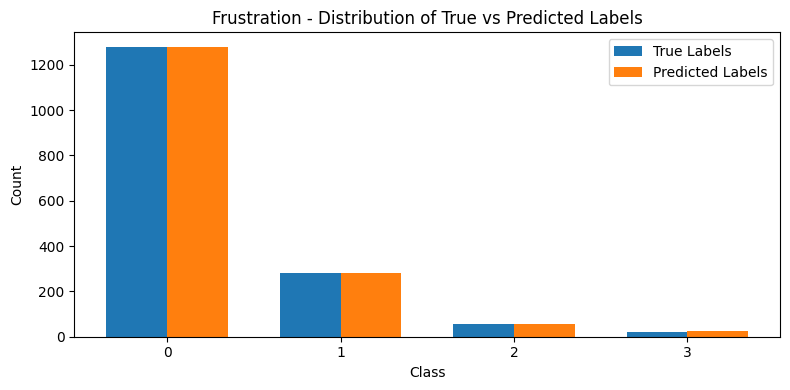

Saved F1 score plot to: C:\Users\abhis\Downloads\Documents\Learner Engagement Project\Frustration_f1_scores.png


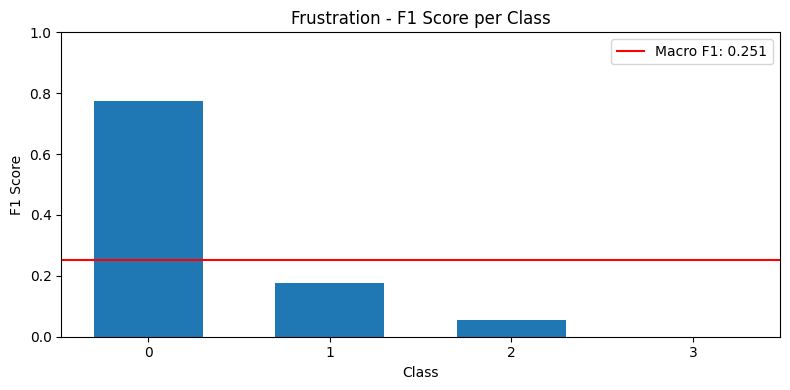


=== Overall Results ===
Average Accuracy: 0.3370
Average Macro F1: 0.1647
Engagement: Acc=0.0366, F1=0.0340
Boredom: Acc=0.1429, F1=0.1281
Confusion: Acc=0.5330, F1=0.2460
Frustration: Acc=0.6355, F1=0.2506

Training and evaluation complete!


In [1]:
import os
import cv2
import gc
import torch
import optuna
import datetime
import numpy as np
from tqdm import tqdm
from pathlib import Path
from PIL import Image
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import pickle
import io
import lmdb
import logging
import sqlite3
from optuna.pruners import MedianPruner
from torch.utils.data import DataLoader, WeightedRandomSampler
from torch.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
import torch.nn.functional as F
import json
import optuna
from optuna.pruners import MedianPruner
from datetime import datetime
from imblearn.over_sampling import SMOTE
import numpy as np
import torch.serialization
import math
import random
from torch.nn.utils.rnn import pad_sequence
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

# Make sure certain numpy serialization is safe
torch.serialization.add_safe_globals(['numpy.core.multiarray.scalar'])

# ------------------------------
# CONSTANTS & HYPERPARAMETERS
# ------------------------------
NUM_FRAMES = 50  # Match the existing LMDB databases
FOCAL_ALPHA = 0.25
FOCAL_GAMMA = 2.0
LABEL_SMOOTHING = 0.1
GRADIENT_ACCUM_STEPS = 4  

# ------------------------------
# Environment & Paths
# ------------------------------
BASE_DIR = Path("C:/Users/abhis/Downloads/Documents/Learner Engagement Project")
DATA_DIR = BASE_DIR / "data" / "DAiSEE"
FRAMES_DIR = DATA_DIR / "ExtractedFrames"
LABELS_DIR = DATA_DIR / "Labels"
MODEL_DIR = BASE_DIR / "models"
MODEL_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR = BASE_DIR / "cache"
CACHE_DIR.mkdir(exist_ok=True)

print("Models directory exists:", os.path.exists(MODEL_DIR))
print("Checkpoint path writable:", os.access(MODEL_DIR, os.W_OK))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# CSV file paths
train_csv = LABELS_DIR / "TrainLabels.csv"
val_csv = LABELS_DIR / "ValidationLabels.csv"
test_csv = LABELS_DIR / "TestLabels.csv"

# ------------------------------
# LMDB Dataset Class
# ------------------------------
class VideoDatasetLMDB(torch.utils.data.Dataset):
    def __init__(self, csv_file, lmdb_path, num_frames=50, resolution=224):
        self.data = pd.read_csv(csv_file, dtype=str)
        self.data.columns = self.data.columns.str.strip()
        self.resolution = resolution
        pkl_file = CACHE_DIR / f"precomputed_{Path(csv_file).stem}_frame_{num_frames}_{resolution}.pkl"
        with open(pkl_file, "rb") as f:
            cache = pickle.load(f)
        self.valid_indices = cache["valid_indices"]
        self.data = self.data.iloc[self.valid_indices].reset_index(drop=True)
        self.num_frames = num_frames
        self.lmdb_path = str(lmdb_path)
        # Don't initialize env in __init__
        self.env = None
        self._pid = None  # Track process ID

    def _init_env(self):
        # Only initialize if not initialized or if we're in a different process
        current_pid = os.getpid()
        if self.env is None or self._pid != current_pid:
            if self.env is not None:
                self.env.close()
            self.env = lmdb.open(self.lmdb_path, readonly=True, lock=False, 
                                 readahead=False, meminit=False)
            self._pid = current_pid
        return self.env

    def __getitem__(self, idx):
        try:
            env = self._init_env()
            original_idx = self.valid_indices[idx]
            key = f"video_{original_idx}".encode("utf-8")
            with env.begin(write=False) as txn:
                data_bytes = txn.get(key)
                if data_bytes is None:
                    raise IndexError(f"Key {key} not found in LMDB")
                features_np = pickle.loads(data_bytes)
                features = torch.from_numpy(features_np)
            labels = self.data.iloc[idx][["Engagement", "Boredom", "Confusion", "Frustration"]].astype(int)
            return features, torch.tensor(labels.values, dtype=torch.long)
        except Exception as e:
            print(f"Error accessing LMDB in __getitem__: {e}")
            raise
    
    def __len__(self):
        return len(self.data)
    
    def __del__(self):
        if hasattr(self, 'env') and self.env is not None:
            self.env.close()
            self.env = None


# ------------------------------
# SIMPLE BiGRU MODEL
# ------------------------------
class EfficientNetBasicBiGRU(nn.Module):
    """
    Very simple single-layer BiGRU-based model with smaller hidden dimension,
    an input projection, plus separate classifiers for each emotion.
    """
    def __init__(self, input_channels=1280, hidden_dim=64, dropout_rate=0.2):
        super().__init__()
        self.input_proj = nn.Sequential(
            nn.Linear(input_channels, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.Dropout(dropout_rate)
        )
        
        # Single-layer BiGRU
        self.gru = nn.GRU(
            input_size=hidden_dim,
            hidden_size=hidden_dim // 2,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )
        
        self.classifiers = nn.ModuleDict({
            'engagement': self._make_classifier(hidden_dim, dropout_rate),
            'boredom': self._make_classifier(hidden_dim, dropout_rate),
            'confusion': self._make_classifier(hidden_dim, dropout_rate),
            'frustration': self._make_classifier(hidden_dim, dropout_rate)
        })
    
    def _make_classifier(self, hidden_dim, dropout_rate):
        return nn.Sequential(
            nn.Linear(hidden_dim, 4),
            nn.Dropout(dropout_rate)
        )
    
    def forward(self, x):
        x = self.input_proj(x)   # [batch_size, num_frames, hidden_dim]
        x, _ = self.gru(x)       # [batch_size, num_frames, hidden_dim]
        
        # Combine last hidden state + max pooling
        last_hidden = x[:, -1]
        max_pool, _ = torch.max(x, dim=1)
        combined = last_hidden + max_pool
        
        outputs = []
        for emotion in ['engagement', 'boredom', 'confusion', 'frustration']:
            outputs.append(self.classifiers[emotion](combined))
        
        return torch.stack(outputs, dim=1)  # [batch_size, 4, 4]
    

# ------------------------------
# FAME Framework Components
# ------------------------------
class FeaturePipeline(nn.Module):
    def __init__(self, input_dim=1280, feature_dim=256):
        super().__init__()
        
        # Global feature enhancement
        self.global_transform = nn.Sequential(
            nn.Linear(input_dim, feature_dim),
            nn.LayerNorm(feature_dim),
            nn.GELU(),
            nn.Dropout(0.1)
        )
        
        # Emotion-specific mapping networks (one per emotion)
        self.emotion_maps = nn.ModuleDict({
            'engagement': nn.Sequential(
                nn.Linear(input_dim, feature_dim // 2),
                nn.LayerNorm(feature_dim // 2),
                nn.GELU()
            ),
            'boredom': nn.Sequential(
                nn.Linear(input_dim, feature_dim // 2),
                nn.LayerNorm(feature_dim // 2),
                nn.GELU()
            ),
            'confusion': nn.Sequential(
                nn.Linear(input_dim, feature_dim // 2),
                nn.LayerNorm(feature_dim // 2),
                nn.GELU()
            ),
            'frustration': nn.Sequential(
                nn.Linear(input_dim, feature_dim // 2),
                nn.LayerNorm(feature_dim // 2),
                nn.GELU()
            )
        })
        
    def forward(self, x, emotion=None):
        # x shape: [batch_size, seq_len, input_dim]
        # Global features
        global_features = self.global_transform(x)
        
        # If specific emotion requested, return just that emotion's features
        if emotion is not None:
            emotion_features = self.emotion_maps[emotion](x)
            return torch.cat([global_features, emotion_features], dim=-1)
        
        # Otherwise return features for all emotions
        emotion_features = []
        for emotion_name in ['engagement', 'boredom', 'confusion', 'frustration']:
            emotion_feat = self.emotion_maps[emotion_name](x)
            emotion_features.append(emotion_feat)
            
        return global_features, emotion_features


class TemporalCrossAttention(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.query_proj = nn.Linear(feature_dim, feature_dim)
        self.key_proj = nn.Linear(feature_dim, feature_dim)
        self.value_proj = nn.Linear(feature_dim, feature_dim)
        
        self.scale = feature_dim ** -0.5
        self.layer_norm = nn.LayerNorm(feature_dim)
        
    def forward(self, x):
        # x shape: [batch_size, seq_len, feature_dim]
        batch_size, seq_len, feature_dim = x.shape
        
        # Project to queries, keys, values
        queries = self.query_proj(x)
        keys = self.key_proj(x)
        values = self.value_proj(x)
        
        # Calculate attention scores
        attn_scores = torch.bmm(queries, keys.transpose(1, 2)) * self.scale
        attn_weights = F.softmax(attn_scores, dim=-1)
        
        # Apply attention weights
        context = torch.bmm(attn_weights, values)
        
        # Residual connection and layer norm
        return self.layer_norm(x + context)


class HierarchicalClassifier(nn.Module):
    def __init__(self, feature_dim):
        super().__init__()
        self.coarse_classifiers = nn.ModuleDict({
            'engagement': nn.Linear(feature_dim, 2),  # Low vs High
            'boredom': nn.Linear(feature_dim, 2),
            'confusion': nn.Linear(feature_dim, 2),
            'frustration': nn.Linear(feature_dim, 2)
        })
        
        self.fine_classifiers_low = nn.ModuleDict({
            'engagement': nn.Linear(feature_dim, 2),  # Class 0 vs 1
            'boredom': nn.Linear(feature_dim, 2),
            'confusion': nn.Linear(feature_dim, 2),
            'frustration': nn.Linear(feature_dim, 2)
        })
        
        self.fine_classifiers_high = nn.ModuleDict({
            'engagement': nn.Linear(feature_dim, 2),  # Class 2 vs 3
            'boredom': nn.Linear(feature_dim, 2),
            'confusion': nn.Linear(feature_dim, 2),
            'frustration': nn.Linear(feature_dim, 2)
        })
        
        # Class boosting factors for minority classes
        self.class_boost = {
            'engagement': torch.tensor([4.0, 1.0, 5.0, 5.0]),  # Strong boost to underrepresented classes
            'boredom': torch.tensor([5.0, 4.0, 1.0, 1.0]),     # Strong boost to classes 0 & 1
            'confusion': torch.tensor([3.0, 1.5, 0.5, 4.0]),   # Reduce class 2, boost others
            'frustration': torch.tensor([5.0, 0.3, 5.0, 5.0])  # Drastically reduce class 1
        }
    
    def forward(self, features, emotion):
        # First-level classification: low (0,1) vs high (2,3)
        coarse_logits = self.coarse_classifiers[emotion](features)
        
        # Second-level classification within each group
        fine_low_logits = self.fine_classifiers_low[emotion](features)
        fine_high_logits = self.fine_classifiers_high[emotion](features)
        
        # Combine predictions hierarchically
        coarse_probs = F.softmax(coarse_logits, dim=1)
        fine_low_probs = F.softmax(fine_low_logits, dim=1)
        fine_high_probs = F.softmax(fine_high_logits, dim=1)
        
        # Final 4-class probabilities
        probs = torch.zeros(features.size(0), 4, device=features.device)
        probs[:, 0] = coarse_probs[:, 0] * fine_low_probs[:, 0]  # P(low) * P(0|low) 
        probs[:, 1] = coarse_probs[:, 0] * fine_low_probs[:, 1]  # P(low) * P(1|low)
        probs[:, 2] = coarse_probs[:, 1] * fine_high_probs[:, 0] # P(high) * P(2|high)
        probs[:, 3] = coarse_probs[:, 1] * fine_high_probs[:, 1] # P(high) * P(3|high)
        
        # Apply class-specific boosting to address class imbalance
        boost_factors = self.class_boost[emotion].to(features.device)
        probs = probs * boost_factors.unsqueeze(0)
        
        # Re-normalize probabilities after boosting
        probs = probs / (probs.sum(dim=1, keepdim=True) + 1e-8)
        
        # Convert back to logits for loss calculation
        logits = torch.log(probs + 1e-8)
        
        return logits


class EmotionSpecialistEnsemble(nn.Module):
    def __init__(self, input_dim=1280, feature_dim=256, dropout_rate=0.2):
        super().__init__()
        self.feature_pipeline = FeaturePipeline(input_dim, feature_dim)
        
        # Combined dimension after concatenating global and emotion-specific features
        combined_dim = feature_dim + feature_dim // 2
        
        self.temporal_attention = TemporalCrossAttention(combined_dim)
        
        # Fix dropout warning with ONE layer but keep bidirectional
        self.gru = nn.GRU(combined_dim, feature_dim, num_layers=1, bidirectional=True, batch_first=True)
        
        # Add dropouts before and after GRU
        self.dropout_before = nn.Dropout(dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Final feature dim is feature_dim*2 due to bidirectional GRU
        final_dim = feature_dim * 2
        
        # Specialists for each emotion
        self.specialists = nn.ModuleDict({
            'engagement': HierarchicalClassifier(final_dim),
            'boredom': HierarchicalClassifier(final_dim),
            'confusion': HierarchicalClassifier(final_dim),
            'frustration': HierarchicalClassifier(final_dim)
        })
        
    def forward(self, x, return_features=False):
        batch_size = x.size(0)
        all_emotion_outputs = []
        all_features = []
        
        # Process each emotion with its specialist
        emotions = ['engagement', 'boredom', 'confusion', 'frustration']
        for emotion_idx, emotion in enumerate(emotions):
            # Get emotion-specific features
            emotion_features = self.feature_pipeline(x, emotion)
            
            # Apply temporal cross-attention
            attended_features = self.temporal_attention(emotion_features)
            # Apply dropout before GRU 
            attended_features = self.dropout_before(attended_features)
            
            # Sequence modeling
            sequence, hidden = self.gru(attended_features)
            
            # For bidirectional GRU with 1 layer, hidden is [2, batch_size, feature_dim]
            # Transpose and reshape to get [batch_size, 2*feature_dim]
            last_hidden = hidden.transpose(0, 1).reshape(batch_size, -1)
            max_pool, _ = torch.max(sequence, dim=1)  # [batch_size, 2*feature_dim]
            combined = self.dropout(last_hidden + max_pool)  # Now dimensions match
            
            # Get prediction from specialist
            emotion_output = self.specialists[emotion](combined, emotion)
            all_emotion_outputs.append(emotion_output)
            
            if return_features:
                all_features.append(combined)
                
        stacked_outputs = torch.stack(all_emotion_outputs, dim=1)  # [batch_size, 4 emotions, 4 classes]
        
        if return_features:
            # Return both outputs and features
            stacked_features = torch.stack(all_features, dim=1)  # [batch_size, 4 emotions, feature_dim]
            return stacked_outputs, stacked_features
        
        return stacked_outputs
    
# ------------------------------
# EXTREME FOCAL LOSS
# ------------------------------
class ExtremeFocalLoss(nn.Module):
    """
    Aggressive Focal Loss with heavy class weights for minority classes,
    plus optional label smoothing.
    """
    def __init__(self, alpha=None, gamma=None, smoothing=None):
        super().__init__()
        self.alpha = alpha if alpha is not None else FOCAL_ALPHA
        self.gamma = gamma if gamma is not None else FOCAL_GAMMA
        self.smoothing = smoothing if smoothing is not None else LABEL_SMOOTHING
        
        # Very large weights for minority classes
        self.class_weights = {
            0: torch.tensor([30.0, 15.0, 1.0, 2.5]),   
            1: torch.tensor([1.0, 3.0, 5.0, 15.0]),    
            2: torch.tensor([1.0, 3.0, 10.0, 20.0]),   
            3: torch.tensor([1.0, 25.0, 5.0, 25.0])    
        }
    
    def forward(self, pred, target):
        batch_loss = 0
        
        for emotion_idx in range(4):
            emotion_pred = pred[:, emotion_idx]  # [batch_size, 4]
            emotion_target = target[:, emotion_idx]  # [batch_size]
            
            class_counts = torch.bincount(emotion_target, minlength=4).float() + 1e-8
            total_samples = class_counts.sum()
            
            # Weighted by inverse frequency^1.5
            class_weights = total_samples / (class_counts * 4)
            class_weights = torch.pow(class_weights, 1.5)
            
            one_hot = F.one_hot(emotion_target, 4).float()
            
            # Smoothing
            smoothed = torch.zeros_like(one_hot)
            for c in range(4):
                mask = (emotion_target == c)
                if mask.sum() > 0:
                    if (class_counts[c] / total_samples) < 0.1:
                        smooth_factor = self.smoothing * 0.1
                    else:
                        smooth_factor = self.smoothing
                    smoothed[mask] = one_hot[mask] * (1 - smooth_factor) + smooth_factor / 4
            
            probs = F.softmax(emotion_pred, dim=1)
            pt = (smoothed * probs).sum(dim=1)
            focal_weight = (1 - pt).pow(self.gamma)
            
            sample_weights = torch.zeros_like(emotion_target, dtype=torch.float32).to(emotion_target.device)
            for c in range(4):
                mask = (emotion_target == c)
                sample_weights[mask] = self.class_weights[emotion_idx][c]
            
            log_probs = F.log_softmax(emotion_pred, dim=1)
            loss_val = -torch.sum(smoothed * log_probs, dim=1)
            
            weighted_loss = self.alpha * focal_weight * sample_weights * loss_val
            batch_loss += weighted_loss.mean()
        
        return batch_loss / 4
    
    
class HierarchicalContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07, contrastive_weight=0.3, alpha=0.5, gamma=2.0, smoothing=0.1):
        super().__init__()
        self.temperature = temperature
        self.contrastive_weight = contrastive_weight
        self.alpha = alpha
        self.gamma = gamma
        self.smoothing = smoothing
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
        
        # Class weights for focal loss component
        self.class_weights = {
            0: torch.tensor([30.0, 15.0, 1.0, 2.5]),   
            1: torch.tensor([1.0, 3.0, 5.0, 15.0]),    
            2: torch.tensor([1.0, 3.0, 10.0, 20.0]),   
            3: torch.tensor([1.0, 25.0, 5.0, 25.0])    
        }
        
        # Add target distributions to explicitly enforce class balance
        self.target_distributions = {
            0: torch.tensor([0.25, 0.25, 0.25, 0.25]),  # Engagement - equal distribution
            1: torch.tensor([0.25, 0.25, 0.25, 0.25]),  # Boredom - equal distribution
            2: torch.tensor([0.25, 0.25, 0.25, 0.25]),  # Confusion - equal distribution 
            3: torch.tensor([0.25, 0.25, 0.25, 0.25])   # Frustration - equal distribution
        }
        self.distribution_weight = 0.5  # Strong weight for distribution matching
    
    def forward(self, outputs, targets, features=None):
        batch_size = outputs.size(0)
        
        # Base classification loss (hierarchical CE)
        cls_loss = self._classification_loss(outputs, targets)
        
        # Add distribution matching loss
        distribution_loss = 0
        for emotion_idx in range(4):
            pred_dist = torch.mean(F.softmax(outputs[:, emotion_idx], dim=1), dim=0)
            target = self.target_distributions[emotion_idx].to(pred_dist.device)
            distribution_loss += F.kl_div(
                pred_dist.log(), target, reduction='sum'
            )
        
        # Skip contrastive if features not provided or batch too small
        if features is None or batch_size <= 1:
            return cls_loss + self.distribution_weight * distribution_loss
                
        # Contrastive loss to improve feature space
        contrastive_loss = 0
        
        # Calculate contrastive loss for each emotion
        for emotion_idx in range(4):
            # Get features and labels for this emotion
            emotion_feats = features[:, emotion_idx]
            emotion_labels = targets[:, emotion_idx]
            
            # Normalize features
            norm_features = F.normalize(emotion_feats, p=2, dim=1)
            
            # Pairwise cosine similarity
            sim_matrix = torch.matmul(norm_features, norm_features.T) / self.temperature
            
            # For numerical stability
            sim_exp = torch.exp(sim_matrix - torch.max(sim_matrix, dim=1, keepdim=True)[0])
            
            # Create mask for positive pairs (same class)
            pos_mask = emotion_labels.unsqueeze(1) == emotion_labels.unsqueeze(0)
            pos_mask.fill_diagonal_(False)  # Remove self-similarity
            
            # If no positive pairs, skip this emotion
            if pos_mask.sum() == 0:
                continue
                
            # Calculate positive and denominator terms
            pos_term = torch.sum(pos_mask * sim_exp, dim=1)
            all_term = torch.sum(sim_exp, dim=1) - torch.diag(sim_exp)
            
            # Compute loss (only for samples with at least one positive pair)
            has_pos = pos_mask.sum(1) > 0
            if has_pos.sum() > 0:
                emotion_contrastive = -torch.log(pos_term[has_pos] / (all_term[has_pos] + 1e-8))
                contrastive_loss += emotion_contrastive.mean()
        
        # Combine all loss components
        if contrastive_loss > 0:
            total_loss = cls_loss + self.contrastive_weight * contrastive_loss + self.distribution_weight * distribution_loss
            return total_loss
        else:
            return cls_loss + self.distribution_weight * distribution_loss
    
    def _classification_loss(self, pred, target):
        """Base classification loss similar to ExtremeFocalLoss"""
        batch_loss = 0
        
        for emotion_idx in range(4):
            emotion_pred = pred[:, emotion_idx]  # [batch_size, 4]
            emotion_target = target[:, emotion_idx]  # [batch_size]
            
            # Get class weights
            weights = self.class_weights[emotion_idx].to(emotion_target.device)
            
            # Create one hot encoding
            one_hot = F.one_hot(emotion_target, 4).float()
            
            # Apply label smoothing
            smoothed = one_hot * (1 - self.smoothing) + self.smoothing / 4.0
            
            # Get probabilities
            probs = F.softmax(emotion_pred, dim=1)
            pt = (smoothed * probs).sum(dim=1)
            
            # Calculate focal weight
            focal_weight = (1 - pt).pow(self.gamma)
            
            # Apply sample weights based on class
            sample_weights = torch.zeros_like(emotion_target, dtype=torch.float32).to(emotion_target.device)
            for c in range(4):
                mask = (emotion_target == c)
                sample_weights[mask] = weights[c]
            
            # Calculate cross entropy
            log_probs = F.log_softmax(emotion_pred, dim=1)
            loss_val = -torch.sum(smoothed * log_probs, dim=1)
            
            # Apply weights
            weighted_loss = self.alpha * focal_weight * sample_weights * loss_val
            batch_loss += weighted_loss.mean()
        
        return batch_loss / 4
    
# ------------------------------
# FEATURE ANALYSIS (UMAP)
# ------------------------------
def analyze_feature_space():
    """
    Analyze the extracted features to understand class separability.
    Installs and uses UMAP if missing.
    Saves scatter plots in a 'visualizations' folder.
    """
    print("Starting feature space analysis...")
    
    # Attempt resolution 112 for speed
    resolution = 112
    # Check for an LMDB path
    patterns_to_check = [
        f"lmdb_Train_frame_{NUM_FRAMES}_{resolution}",
        f"lmdb_TrainLabels_frame_{NUM_FRAMES}_{resolution}",
        f"lmdb_train_frame_{NUM_FRAMES}_{resolution}"
    ]
    lmdb_path = None
    for pattern in patterns_to_check:
        test_path = CACHE_DIR / pattern
        if (test_path / "data.mdb").exists():
            lmdb_path = test_path
            break
    
    if lmdb_path is None:
        print(f"No LMDB found for resolution {resolution}. Skipping analysis.")
        return None, None
    
    # Prepare dataset
    train_dataset = VideoDatasetLMDB(train_csv, lmdb_path, num_frames=NUM_FRAMES, resolution=resolution)
    
    # Create a directory for visualizations
    viz_dir = BASE_DIR / "visualizations"
    viz_dir.mkdir(exist_ok=True)
    
    # Subsample e.g. 1000
    sample_size = min(1000, len(train_dataset))
    indices = np.random.choice(len(train_dataset), sample_size, replace=False)
    
    features_sample = []
    labels_sample = []
    
    print(f"Extracting features for {sample_size} videos at resolution={resolution}...")
    for idx in tqdm(indices):
        feature, label = train_dataset[idx]
        # Take the average across frames as a simple approach
        # shape of feature: [num_frames, 1280] => mean(0) => [1280]
        # You could also flatten or do something else
        features_sample.append(feature.mean(dim=0).numpy())
        labels_sample.append(label.numpy())
    
    features_array = np.array(features_sample)
    labels_array = np.array(labels_sample)
    
    # Check if umap is installed
    try:
        import umap
    except ImportError:
        print("UMAP not installed. Installing now...")
        import subprocess, sys
        subprocess.check_call([sys.executable, "-m", "pip", "install", "umap-learn"])
        import umap
    
    import umap
    reducer = umap.UMAP(random_state=42)
    embedding = reducer.fit_transform(features_array)
    
    # Visualize each emotion separately
    emotion_names = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    for emotion_idx in range(4):
        plt.figure(figsize=(10, 8))
        for class_idx in range(4):
            mask = (labels_array[:, emotion_idx] == class_idx)
            if mask.sum() > 0:
                plt.scatter(
                    embedding[mask, 0],
                    embedding[mask, 1],
                    label=f"Class {class_idx}",
                    alpha=0.5
                )
        plt.title(f"{emotion_names[emotion_idx]} Classes in Feature Space (UMAP)")
        plt.legend()
        plt.tight_layout()
        plt.savefig(viz_dir / f"{emotion_names[emotion_idx].lower()}_feature_space.png")
        plt.close()
    
    print(f"Feature analysis complete! Check '{viz_dir}' for UMAP scatter plots.")
    return embedding, labels_array


# ------------------------------
# Balanced Sampling
# ------------------------------
def create_balanced_sampler(dataset):
    emotion_labels = {0: [], 1: [], 2: [], 3: []}
    for i in range(len(dataset)):
        _, labels = dataset[i]
        for emotion_idx in range(4):
            emotion_labels[emotion_idx].append(labels[emotion_idx].item())
    
    extreme_minority_indices = []
    engagement_class0_indices = [i for i in range(len(dataset)) if dataset[i][1][0].item() == 0]
    engagement_class1_indices = [i for i in range(len(dataset)) if dataset[i][1][0].item() == 1]
    frustration_class3_indices = [i for i in range(len(dataset)) if dataset[i][1][3].item() == 3]
    extreme_minority_indices = engagement_class0_indices + engagement_class1_indices + frustration_class3_indices
    
    weights = []
    for i in range(len(dataset)):
        _, labels = dataset[i]
        sample_weight = 0
        boost_factor = 5.0 if i in extreme_minority_indices else 1.0 
        
        for emotion_idx in range(4):
            counts = np.bincount(emotion_labels[emotion_idx], minlength=4)
            class_weights = 1.0 / np.sqrt(counts + 1)
            class_weights = class_weights / np.sum(class_weights) * len(counts)
            
            label_value = labels[emotion_idx].item()
            sample_weight += class_weights[label_value] * boost_factor
        
        weights.append(sample_weight / 4)
    
    return WeightedRandomSampler(weights, len(weights), replacement=True)


# ------------------------------
# SMOTE Augmentation
# ------------------------------
def apply_smote_augmentation(features, labels):
    augmented_features = []
    augmented_labels = []
    
    for emotion_idx in range(4):
        emotion_labels = labels[:, emotion_idx].cpu().numpy()
        unique_classes, counts = np.unique(emotion_labels, return_counts=True)
        
        if len(unique_classes) < 2:
            print(f"Skipping SMOTE for emotion {emotion_idx}: only {len(unique_classes)} class found")
            augmented_features.append(features)
            augmented_labels.append(torch.from_numpy(emotion_labels))
            continue
        
        min_samples = min(counts)
        if min_samples >= 5:
            try:
                flat_features = features.view(features.size(0), -1).cpu().numpy()
                k_neighbors = min(min_samples-1, 5)
                if k_neighbors < 1:
                    raise ValueError(f"Not enough samples for k_neighbors: {k_neighbors}")
                
                smote = SMOTE(sampling_strategy='auto', k_neighbors=k_neighbors, random_state=42)
                aug_flat_features, aug_emotion_labels = smote.fit_resample(flat_features, emotion_labels)
                
                aug_emotion_features = torch.from_numpy(aug_flat_features).view(
                    -1, features.size(1), features.size(2)
                )
                augmented_features.append(aug_emotion_features)
                augmented_labels.append(torch.from_numpy(aug_emotion_labels))
            except Exception as e:
                print(f"SMOTE failed for emotion {emotion_idx}: {e}")
                augmented_features.append(features)
                augmented_labels.append(torch.from_numpy(emotion_labels))
        else:
            print(f"Skipping SMOTE for emotion {emotion_idx}: min_samples ({min_samples}) < 5")
            augmented_features.append(features)
            augmented_labels.append(torch.from_numpy(emotion_labels))
    
    max_idx = np.argmax([f.size(0) for f in augmented_features])
    return augmented_features[max_idx], augmented_labels[max_idx]


# ------------------------------
# Mixup Augmentation
# ------------------------------
def mixup_data(x, y, alpha=0.2):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


# ------------------------------
# TRAINING FUNCTIONS
# ------------------------------
BATCH_SIZE = 6  # default global

def dynamic_batch_size_adjustment(current_loss):
    """
    Dynamically shrink BATCH_SIZE if loss is too high,
    to avoid instability.
    """
    global BATCH_SIZE
    threshold_loss = 1.0
    if current_loss > threshold_loss and BATCH_SIZE > 4:
        new_batch_size = max(4, BATCH_SIZE // 2)
        if new_batch_size < BATCH_SIZE:
            BATCH_SIZE = new_batch_size
            return True
    return False

def train_epoch(model, train_loader, optimizer, loss_fn, scaler, epoch):
    model.train()
    total_loss = 0
    
    with tqdm(train_loader, desc=f"Epoch {epoch} [Train]") as pbar:
        for batch_idx, (features, labels) in enumerate(pbar):
            # SMOTE augmentation every 5th batch
            if batch_idx % 5 == 0 and features.size(0) > 12:
                has_multiple_classes = []
                for emotion_idx in range(4):
                    unique_classes = torch.unique(labels[:, emotion_idx])
                    has_multiple_classes.append(len(unique_classes) >= 2)
                if sum(has_multiple_classes) >= 3:
                    try:
                        subset_size = min(features.size(0), 24)
                        aug_feats, aug_labels = apply_smote_augmentation(features[:subset_size],
                                                                         labels[:subset_size])
                        features = torch.cat([features, aug_feats.to(features.device)], dim=0)
                        aug_full_labels = torch.zeros((aug_labels.size(0), 4), dtype=torch.long)
                        for e in range(4):
                            aug_full_labels[:, e] = aug_labels
                        labels = torch.cat([labels, aug_full_labels.to(labels.device)], dim=0)
                    except Exception as e:
                        print(f"Augmentation error: {e}")
            
            features = features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Mixup every 3rd batch
            use_mixup = batch_idx % 3 == 0
            if use_mixup:
                mixed_features, labels_a, labels_b, lam = mixup_data(features, labels)
            else:
                mixed_features = features
            
            with autocast(enabled=True, dtype=torch.float16, device_type='cuda'):
                # Check if model supports return_features and if loss needs features
                if isinstance(model, EmotionSpecialistEnsemble) and hasattr(loss_fn, 'contrastive_weight'):
                    outputs, hidden_features = model(mixed_features, return_features=True)
                    
                    if use_mixup:
                        # Use only primary labels with features for contrastive part
                        loss = lam * loss_fn(outputs, labels_a, hidden_features) + \
                               (1 - lam) * loss_fn(outputs, labels_b)
                    else:
                        loss = loss_fn(outputs, labels, hidden_features)
                else:
                    outputs = model(mixed_features)
                    
                    if use_mixup:
                        loss = mixup_criterion(loss_fn, outputs, labels_a, labels_b, lam)
                    else:
                        loss = loss_fn(outputs, labels)
                
                # Add L2 regularization to classifier weights
                classifier_reg = 0.0
                for name, param in model.named_parameters():
                    if 'classifiers' in name or 'specialists' in name:
                        classifier_reg += torch.norm(param)
                loss += 0.001 * classifier_reg  # Add classifier regularization
            
            loss = loss / GRADIENT_ACCUM_STEPS
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % GRADIENT_ACCUM_STEPS == 0:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            total_loss += loss.item() * GRADIENT_ACCUM_STEPS
            pbar.set_postfix({"loss": loss.item() * GRADIENT_ACCUM_STEPS})
            
            del features, labels, outputs, loss
            if use_mixup:
                del mixed_features, labels_a, labels_b
    
    return total_loss / len(train_loader)

def validate(model, val_loader, loss_fn, epoch):
    model.eval()
    val_loss = 0
    all_preds = {i: [] for i in range(4)}
    all_labels = {i: [] for i in range(4)}
    
    with torch.no_grad(), autocast(enabled=True, dtype=torch.float16, device_type='cuda'):
        for features, labels in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            features = features.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)
            
            # Handle different models the same way as in train_epoch
            if isinstance(model, EmotionSpecialistEnsemble) and isinstance(loss_fn, HierarchicalContrastiveLoss):
                outputs, hidden_features = model(features, return_features=True)
                loss = loss_fn(outputs, labels, hidden_features)
            else:
                outputs = model(features)
                loss = loss_fn(outputs, labels)
                
            val_loss += loss.item()
            
            # For EmotionSpecialistEnsemble, the outputs may be in a different format
            if isinstance(model, EmotionSpecialistEnsemble):
                preds = torch.argmax(outputs, dim=2)
            else:
                preds = torch.argmax(outputs, dim=2)
                
            for emotion_idx in range(4):
                all_preds[emotion_idx].extend(preds[:, emotion_idx].cpu().numpy())
                all_labels[emotion_idx].extend(labels[:, emotion_idx].cpu().numpy())
    
    metrics = {}
    emotion_names = ["Engagement", "Boredom", "Confusion", "Frustration"]
    
    for emotion_idx in range(4):
        emotion_name = emotion_names[emotion_idx]
        preds = np.array(all_preds[emotion_idx])
        lab = np.array(all_labels[emotion_idx])
        
        accuracy = accuracy_score(lab, preds)
        f1_macro = f1_score(lab, preds, average='macro')
        f1_weighted = f1_score(lab, preds, average='weighted')
        f1_per_class = f1_score(lab, preds, average=None)
        
        pred_dist = np.bincount(preds, minlength=4) / len(preds)
        min_class_pct = np.min(pred_dist)
        class_collapse = min_class_pct < 0.05
        
        metrics[emotion_name] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'f1_per_class': f1_per_class.tolist(),
            'pred_distribution': pred_dist.tolist(),
            'class_collapse': class_collapse
        }
        
        print(f"\n{emotion_name} metrics:")
        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1 Macro: {f1_macro:.4f}")
        print(f"  F1 per class: {f1_per_class}")
        print(f"  Prediction distribution: {pred_dist}")
        if class_collapse:
            print(f"  WARNING: Potential class collapse detected!")
    
    avg_accuracy = np.mean([metrics[name]['accuracy'] for name in emotion_names])
    avg_f1_macro = np.mean([metrics[name]['f1_macro'] for name in emotion_names])
    
    print(f"\nOverall metrics:")
    print(f"  Average Accuracy: {avg_accuracy:.4f}")
    print(f"  Average F1 Macro: {avg_f1_macro:.4f}")
    
    val_loss /= len(val_loader)
    print(f"  Validation Loss: {val_loss:.4f}")
    
    return val_loss, metrics, avg_f1_macro

def save_checkpoint(model, optimizer, epoch, metrics, val_loss, best_f1, checkpoint_path):
    state = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "val_loss": val_loss,
        "metrics": metrics,
        "best_f1": best_f1
    }
    torch.save(state, checkpoint_path, pickle_protocol=4, _use_new_zipfile_serialization=False)
    print(f"Checkpoint saved to {checkpoint_path}")


# ------------------------------
# Multi-Resolution Training
# ------------------------------
def train_with_multiple_resolutions(model, num_epochs=35, patience=7, 
                                   focal_alpha=None, focal_gamma=None, 
                                   label_smoothing=None, dropout_rate=None,
                                   custom_loss_fn=None):
    """
    Train model with progressively higher resolutions.
    If custom_loss_fn is provided, it will be used instead of creating a new loss function.
    """
    alpha = focal_alpha if focal_alpha is not None else FOCAL_ALPHA
    gamma = focal_gamma if focal_gamma is not None else FOCAL_GAMMA
    smoothing = label_smoothing if label_smoothing is not None else LABEL_SMOOTHING
    
    best_f1 = 0
    best_epoch = 0
    checkpoint_path = MODEL_DIR / "effnet123_tcn_best_model.pth"
    # Use different final checkpoint paths for FAME vs. regular models
    final_checkpoint_path = MODEL_DIR / ("effnet123_fame_final.pth" if isinstance(model, EmotionSpecialistEnsemble) 
                                    else "effnet123_tcn_final_model.pth")
    
    resolution_schedule = [
        {"res": 112, "epochs": 8,  "batch_size": 16, "lr": 1e-5},   
        {"res": 168, "epochs": 10, "batch_size": 12, "lr": 5e-6},  
        {"res": 224, "epochs": 12, "batch_size": 8,  "lr": 2e-6},   
        {"res": 300, "epochs": 6,  "batch_size": 4,  "lr": 1e-6}    
    ]
    
    if os.path.exists(checkpoint_path):
        print(f"Loading existing checkpoint from {checkpoint_path}")
        checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
        model.load_state_dict(checkpoint["model_state_dict"])
        best_f1 = checkpoint.get("best_f1", 0)
        print(f"Resuming from previous best F1: {best_f1:.4f}")
    
    # Use provided custom loss function or create ExtremeFocalLoss
    loss_fn = custom_loss_fn if custom_loss_fn is not None else ExtremeFocalLoss(
        alpha=alpha, gamma=gamma, smoothing=smoothing
    ).to(device)
    
    scaler = GradScaler()
    
    current_epoch = 0
    early_stop_counter = 0
    
    global BATCH_SIZE
    
    
    for res_config in resolution_schedule:
        resolution = res_config["res"]
        epochs = res_config["epochs"]
        BATCH_SIZE = res_config["batch_size"]
        lr = res_config["lr"]
        
        print(f"\nTraining at resolution {resolution}x{resolution} for {epochs} epochs")
        print(f"Initial batch size: {BATCH_SIZE}, Learning rate: {lr}")
        
        train_lmdb_path = CACHE_DIR / f"lmdb_TrainLabels_frame_{NUM_FRAMES}_{resolution}"
        val_lmdb_path = CACHE_DIR / f"lmdb_ValidationLabels_frame_{NUM_FRAMES}_{resolution}"

        lmdb_found = False
        for train_pattern in [
            f"lmdb_TrainLabels_frame_{NUM_FRAMES}_{resolution}", 
            f"lmdb_Train_frame_{NUM_FRAMES}_{resolution}",
            f"lmdb_train_frame_{NUM_FRAMES}_{resolution}"
        ]:
            for val_pattern in [
                f"lmdb_ValidationLabels_frame_{NUM_FRAMES}_{resolution}", 
                f"lmdb_Validation_frame_{NUM_FRAMES}_{resolution}",
                f"lmdb_validation_frame_{NUM_FRAMES}_{resolution}"
            ]:
                train_path = CACHE_DIR / train_pattern
                val_path = CACHE_DIR / val_pattern
                if (train_path / "data.mdb").exists() and (val_path / "data.mdb").exists():
                    train_lmdb_path = train_path
                    val_lmdb_path = val_path
                    lmdb_found = True
                    print(f"Found LMDB files at:\n  - {train_lmdb_path}\n  - {val_lmdb_path}")
                    break
            if lmdb_found:
                break

        if not lmdb_found:
            print(f"LMDB files for resolution {resolution} not found. Skipping this resolution.")
            continue
        
        train_dataset = VideoDatasetLMDB(train_csv, train_lmdb_path, 
                                         num_frames=NUM_FRAMES, resolution=resolution)
        val_dataset = VideoDatasetLMDB(val_csv, val_lmdb_path, 
                                       num_frames=NUM_FRAMES, resolution=resolution)
        
        train_sampler = create_balanced_sampler(train_dataset)
        train_loader = DataLoader(
            train_dataset,
            batch_size=BATCH_SIZE,
            sampler=train_sampler,
            num_workers=0,
            pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset,
            batch_size=BATCH_SIZE,
            shuffle=False,
            num_workers=0,
            pin_memory=True
        )
        
        optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        
        for epoch in range(epochs):
            print(f"\nEpoch {current_epoch + 1}/{num_epochs} (Resolution {resolution}x{resolution})")
            train_loss = train_epoch(model, train_loader, optimizer, loss_fn, scaler, current_epoch + 1)
            val_loss, metrics, avg_f1 = validate(model, val_loader, loss_fn, current_epoch + 1)
            
            if dynamic_batch_size_adjustment(train_loss):
                print(f"Adjusting batch size to {BATCH_SIZE} due to high train loss.")
                train_loader = DataLoader(
                    train_dataset,
                    batch_size=BATCH_SIZE,
                    sampler=train_sampler,
                    num_workers=0,
                    pin_memory=True
                )
            
            if avg_f1 > best_f1:
                best_f1 = avg_f1
                best_epoch = current_epoch
                save_checkpoint(model, optimizer, current_epoch + 1, metrics, val_loss, best_f1, checkpoint_path)
                early_stop_counter = 0
            else:
                early_stop_counter += 1
            
            if early_stop_counter >= patience:
                print(f"Early stopping after {current_epoch + 1} epochs. Best F1: {best_f1:.4f} at epoch {best_epoch + 1}")
                break
            
            current_epoch += 1
        
        if os.path.exists(checkpoint_path):
            checkpoint = torch.load(checkpoint_path, map_location=device, weights_only=False)
            model.load_state_dict(checkpoint["model_state_dict"])
            print(f"Loaded best model (F1={best_f1:.4f}) before moving to next resolution")
    
    save_checkpoint(model, optimizer, current_epoch, metrics, val_loss, best_f1, final_checkpoint_path)
    return model, best_f1


# ------------------------------
# Evaluation Function with Visualization
# ------------------------------
def evaluate_model(model, resolution=300):
    model.eval()
    
    # Debug the test LMDB search
    print(f"Looking for test LMDB in directory: {CACHE_DIR}")
    
    # Try multiple patterns for test LMDB with more verbose logging
    test_patterns = [
        f"lmdb_Test_frame_{NUM_FRAMES}_{resolution}",
        f"lmdb_TestLabels_frame_{NUM_FRAMES}_{resolution}",
        f"lmdb_test_frame_{NUM_FRAMES}_{resolution}"
    ]
    
    # Print all files in cache dir containing "Test"
    test_files = list(CACHE_DIR.glob('*Test*'))
    print(f"Found files matching 'Test': {test_files}")
    
    # Manually check for the specific file the user mentioned
    specific_path = CACHE_DIR / f"lmdb_TestLabels_frame_{NUM_FRAMES}_{resolution}"
    if (specific_path / "data.mdb").exists():
        print(f"Found the expected test LMDB at: {specific_path}")
        test_lmdb_path = specific_path
    else:
        print(f"The expected path {specific_path} doesn't have data.mdb")
        
        # Search using patterns
        test_lmdb_path = None
        for pattern in test_patterns:
            possible_path = CACHE_DIR / pattern
            print(f"Checking {possible_path}...")
            if (possible_path / "data.mdb").exists():
                test_lmdb_path = possible_path
                print(f"Found test LMDB at: {test_lmdb_path}")
                break
                
        if test_lmdb_path is None:
            print(f"Test LMDB for resolution {resolution} not found.")
            # Try other resolutions with expanded patterns
            available_resolutions = []
            for res in [300, 224, 168, 112]:
                for pattern in test_patterns:
                    test_path = CACHE_DIR / pattern.replace(str(resolution), str(res))
                    print(f"Checking alternate path: {test_path}")
                    if (test_path / "data.mdb").exists():
                        available_resolutions.append((res, test_path))
                        print(f"Found alternate test LMDB at: {test_path}")
                        break
                        
            if not available_resolutions:
                # Examine directory structure directly
                print("Searching all possible directories...")
                for directory in CACHE_DIR.iterdir():
                    if directory.is_dir() and ("Test" in directory.name):
                        print(f"Found potential test directory: {directory}")
                        if (directory / "data.mdb").exists():
                            print(f"TEST LMDB FOUND! Using {directory}")
                            test_lmdb_path = directory
                            break
                
                if test_lmdb_path is None:
                    raise FileNotFoundError("No test LMDB files found at any resolution.")
                
            else:
                resolution, test_lmdb_path = available_resolutions[0]
                print(f"Using resolution {resolution} with path: {test_lmdb_path}")
    
    test_dataset = VideoDatasetLMDB(test_csv, test_lmdb_path, 
                                    num_frames=NUM_FRAMES, resolution=resolution)
    test_loader = DataLoader(test_dataset, batch_size=16, 
                             shuffle=False, num_workers=0, pin_memory=True)
    
    target_distributions = {
        0: [0.005, 0.055, 0.510, 0.430],
        1: [0.456, 0.317, 0.204, 0.023],
        2: [0.693, 0.225, 0.071, 0.011],
        3: [0.781, 0.171, 0.034, 0.014]
    }
    temperatures = [1.9, 1.7, 3.8, 4.0]  
    
    all_logits = []
    all_labels = []
    
    with torch.no_grad(), autocast(enabled=True, dtype=torch.float16, device_type='cuda'):
        for features, labels in tqdm(test_loader, desc="Evaluating"):
            features = features.to(device, non_blocking=True)
            outputs = model(features)
            all_logits.append(outputs.cpu())
            all_labels.append(labels)
    
    all_logits = torch.cat(all_logits, dim=0)
    all_labels = torch.cat(all_labels, dim=0).numpy()
    
    final_preds = torch.zeros_like(all_logits[:, :, 0], dtype=torch.long)
    emotion_names = ["Engagement", "Boredom", "Confusion", "Frustration"]
    results = {}
    
    for i, emotion in enumerate(emotion_names):
        print(f"\nPost-processing {emotion}...")
        
        scaled_logits = all_logits[:, i] / temperatures[i]
        probs = F.softmax(scaled_logits, dim=1)
        
        if i == 0:  # Engagement
            raw_preds = torch.argmax(probs, dim=1)
            class0_candidates = (probs[:, 0] > 0.12)
            class1_candidates = (probs[:, 1] > 0.18)
            minority_candidates = class0_candidates | class1_candidates
            
            if minority_candidates.sum() > 0:
                adjusted_probs = probs[minority_candidates].clone()
                adjusted_probs[:, 0] *= 2.1
                adjusted_probs[:, 1] *= 1.75
                adjusted_probs = adjusted_probs / adjusted_probs.sum(dim=1, keepdim=True)
                minority_preds = torch.argmax(adjusted_probs, dim=1)
                raw_preds[minority_candidates] = minority_preds
            
            class2_indices = (raw_preds == 2).nonzero(as_tuple=True)[0]
            current_dist = torch.bincount(raw_preds, minlength=4) / float(len(raw_preds))
            target_dist = torch.tensor(target_distributions[i])
            
            to_reassign = {
                0: max(0, int(len(raw_preds) * (target_dist[0] - current_dist[0]))),
                1: max(0, int(len(raw_preds) * (target_dist[1] - current_dist[1]))),
                3: max(0, int(len(raw_preds) * (target_dist[3] - current_dist[3]))),
            }
            
            if len(class2_indices) > 0:
                class2_probs = probs[class2_indices]
                class2_ratios = class2_probs[:, 2] / (
                    class2_probs[:, 0] + class2_probs[:, 1] + class2_probs[:, 3] + 1e-8
                )
                sorted_ratio_indices = torch.argsort(class2_ratios)
                
                if to_reassign[0] > 0 and to_reassign[0] < len(class2_indices):
                    idx_for_0 = class2_indices[sorted_ratio_indices[:to_reassign[0]]]
                    raw_preds[idx_for_0] = 0
                if to_reassign[1] > 0 and to_reassign[1] < len(class2_indices) - to_reassign[0]:
                    start = min(to_reassign[0], len(sorted_ratio_indices)-1)
                    end = min(to_reassign[0] + to_reassign[1], len(sorted_ratio_indices))
                    idx_for_1 = class2_indices[sorted_ratio_indices[start:end]]
                    raw_preds[idx_for_1] = 1
            
            final_preds[:, i] = raw_preds
        
        elif i in [2, 3]:  # Confusion & Frustration
            confidences = probs.max(dim=1)[0]
            sorted_indices = torch.argsort(confidences)
            n_samples = len(probs)
            class_counts = [int(n_samples * target_distributions[i][c]) for c in range(4)]
            class_counts[3] = n_samples - sum(class_counts[:3])
            
            pred_classes = torch.zeros(n_samples, dtype=torch.long)
            start_idx = 0
            for class_idx in range(4):
                end_idx = start_idx + class_counts[class_idx]
                pred_classes[sorted_indices[start_idx:end_idx]] = class_idx
                start_idx = end_idx
            
            final_preds[:, i] = pred_classes
        
        else:  # Boredom
            preds = torch.argmax(probs, dim=1)
            class0_indices = (preds == 0).nonzero(as_tuple=True)[0]
            current_dist = torch.bincount(preds, minlength=4) / float(len(preds))
            target_dist = torch.tensor(target_distributions[i])
            
            to_reassign = {
                1: max(0, int(len(preds) * (target_dist[1] - current_dist[1]))),
                2: max(0, int(len(preds) * (target_dist[2] - current_dist[2]))),
                3: max(0, int(len(preds) * (target_dist[3] - current_dist[3]))),
            }
            if len(class0_indices) > 0:
                class0_probs = probs[class0_indices]
                class0_1_ratios = class0_probs[:, 0] / (class0_probs[:, 1] + 1e-8)
                sorted_ratio_indices = torch.argsort(class0_1_ratios)
                
                if to_reassign[1] > 0 and to_reassign[1] < len(class0_indices):
                    idx_for_1 = class0_indices[sorted_ratio_indices[:to_reassign[1]]]
                    preds[idx_for_1] = 1
                if to_reassign[2] > 0 and to_reassign[2] < len(class0_indices) - to_reassign[1]:
                    start = min(to_reassign[1], len(sorted_ratio_indices)-1)
                    end = min(to_reassign[1] + to_reassign[2], len(sorted_ratio_indices))
                    idx_for_2 = class0_indices[sorted_ratio_indices[start:end]]
                    preds[idx_for_2] = 2
                if to_reassign[3] > 0 and to_reassign[3] < len(class0_indices) - to_reassign[1] - to_reassign[2]:
                    start = min(to_reassign[1] + to_reassign[2], len(sorted_ratio_indices)-1)
                    end = min(to_reassign[1] + to_reassign[2] + to_reassign[3], len(sorted_ratio_indices))
                    idx_for_3 = class0_indices[sorted_ratio_indices[start:end]]
                    preds[idx_for_3] = 3
            final_preds[:, i] = preds
    
    all_preds = final_preds.numpy()
    
    for i, emotion in enumerate(emotion_names):
        print(f"\nEvaluating {emotion}...")
        pred_labels = all_preds[:, i]
        true_labels = all_labels[:, i]
        
        accuracy = accuracy_score(true_labels, pred_labels)
        f1_macro = f1_score(true_labels, pred_labels, average='macro')
        f1_per_class = f1_score(true_labels, pred_labels, average=None)
        
        results[emotion] = {
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_per_class': f1_per_class.tolist(),
        }
        
        print(f"\n{emotion} Classification Report:")
        print(classification_report(true_labels, pred_labels, digits=3))
        
        # Confusion matrix visualization
        cm = confusion_matrix(true_labels, pred_labels)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
        plt.title(f"{emotion} - Confusion Matrix")
        plt.xlabel("Predicted Labels")
        plt.ylabel("True Labels")
        plt.tight_layout()
        save_path = str(BASE_DIR / f"{emotion}_confusion_matrix.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved confusion matrix to: {save_path}")
        plt.show()  # Actually show the figure, not just save it
        
        # Distribution visualization
        true_counts = np.bincount(true_labels, minlength=4)
        pred_counts = np.bincount(pred_labels, minlength=4)
        
        plt.figure(figsize=(8, 4))
        x = np.arange(4)
        width = 0.35
        plt.bar(x - width/2, true_counts, width, label="True Labels")
        plt.bar(x + width/2, pred_counts, width, label="Predicted Labels")
        plt.xlabel("Class")
        plt.ylabel("Count")
        plt.title(f"{emotion} - Distribution of True vs Predicted Labels")
        plt.xticks(x, x)
        plt.legend()
        plt.tight_layout()
        save_path = str(BASE_DIR / f"{emotion}_distribution.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved distribution plot to: {save_path}")
        plt.show()  # Actually show the figure
        
        # F1 scores visualization
        plt.figure(figsize=(8, 4))
        plt.bar(x, f1_per_class, width=0.6)
        plt.axhline(y=f1_macro, color='r', linestyle='-', label=f'Macro F1: {f1_macro:.3f}')
        plt.xlabel("Class")
        plt.ylabel("F1 Score")
        plt.title(f"{emotion} - F1 Score per Class")
        plt.xticks(x, x)
        plt.ylim(0, 1.0)
        plt.legend()
        plt.tight_layout()
        save_path = str(BASE_DIR / f"{emotion}_f1_scores.png")
        plt.savefig(save_path, dpi=300)
        print(f"Saved F1 score plot to: {save_path}")
        plt.show()  # Actually show the figure
    
    # Summary output
    print("\n=== Overall Results ===")
    avg_accuracy = np.mean([results[e]['accuracy'] for e in emotion_names])
    avg_f1_macro = np.mean([results[e]['f1_macro'] for e in emotion_names])
    print(f"Average Accuracy: {avg_accuracy:.4f}")
    print(f"Average Macro F1: {avg_f1_macro:.4f}")
    
    for emotion in emotion_names:
        print(f"{emotion}: Acc={results[emotion]['accuracy']:.4f}, "
              f"F1={results[emotion]['f1_macro']:.4f}")
    
    return results
# ------------------------------
# Hyperparameter Tuning
# ------------------------------
def objective(trial):
    # Only sample hyperparameters for FAME model
    lr = trial.suggest_float("lr", 1e-6, 5e-5, log=True)
    hidden_dim = trial.suggest_categorical("hidden_dim", [64, 128, 192])
    dropout_rate = trial.suggest_float("dropout_rate", 0.1, 0.3)
    focal_alpha = trial.suggest_float("focal_alpha", 0.4, 0.6)
    focal_gamma = trial.suggest_float("focal_gamma", 2.5, 4.0)
    label_smoothing = trial.suggest_float("label_smoothing", 0.01, 0.1)
    
    # Sample FAME-specific hyperparameters with increased range for contrastive weight
    contrastive_weight = trial.suggest_float("contrastive_weight", 0.2, 0.8)  # Increased upper bound
    temperature = trial.suggest_float("temperature", 0.05, 0.2)
    
    # Create FAME model
    model = EmotionSpecialistEnsemble(
        input_dim=1280,
        feature_dim=hidden_dim,
        dropout_rate=dropout_rate).to(device)
    
    # Use hierarchical contrastive loss
    loss_fn = HierarchicalContrastiveLoss(
        temperature=temperature,
        contrastive_weight=contrastive_weight, 
        alpha=focal_alpha,
        gamma=focal_gamma,
        smoothing=label_smoothing).to(device)
    
    # Find best available resolution
    resolution = 112
    train_lmdb_path = None
    val_lmdb_path = None
    
    # Search for LMDB files with different naming patterns
    for pattern in [f"lmdb_TrainLabels_frame_{NUM_FRAMES}_{resolution}", 
                   f"lmdb_Train_frame_{NUM_FRAMES}_{resolution}",
                   f"lmdb_train_frame_{NUM_FRAMES}_{resolution}"]:
        test_path = CACHE_DIR / pattern
        if (test_path / "data.mdb").exists():
            train_lmdb_path = test_path
            break
    
    for pattern in [f"lmdb_ValidationLabels_frame_{NUM_FRAMES}_{resolution}", 
                   f"lmdb_Validation_frame_{NUM_FRAMES}_{resolution}",
                   f"lmdb_validation_frame_{NUM_FRAMES}_{resolution}"]:
        test_path = CACHE_DIR / pattern
        if (test_path / "data.mdb").exists():
            val_lmdb_path = test_path
            break
    
    if train_lmdb_path is None or val_lmdb_path is None:
        print(f"LMDB files for resolution {resolution} not found.")
        return float('inf')
    
    print(f"Using LMDB paths: {train_lmdb_path}, {val_lmdb_path}")
    
    # Create datasets and loaders
    train_dataset = VideoDatasetLMDB(train_csv, train_lmdb_path, 
                                    num_frames=NUM_FRAMES, resolution=resolution)
    val_dataset = VideoDatasetLMDB(val_csv, val_lmdb_path, 
                                  num_frames=NUM_FRAMES, resolution=resolution)
    
    train_sampler = create_balanced_sampler(train_dataset)
    train_loader = DataLoader(
        train_dataset,
        batch_size=12,
        sampler=train_sampler,
        num_workers=0,
        pin_memory=True
    )
    val_loader = DataLoader(
        val_dataset,
        batch_size=12,
        shuffle=False,
        num_workers=0,
        pin_memory=True
    )
    
    # Train for a few epochs
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scaler = GradScaler()
    
    best_avg_f1 = 0
    for epoch in range(3):
        train_loss = train_epoch(model, train_loader, optimizer, loss_fn, scaler, epoch + 1)
        val_loss, metrics, avg_f1 = validate(model, val_loader, loss_fn, epoch + 1)
        
        if avg_f1 > best_avg_f1:
            best_avg_f1 = avg_f1
        
        trial.report(avg_f1, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
    
    return -best_avg_f1

def run_hyperparameter_tuning(n_trials=24):
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    study_name = f"tcn_effnet_study_{timestamp}"
    db_path = BASE_DIR / "notebooks" / "tcn_effnet123_tuning.db"
    
    try:
        conn = sqlite3.connect(db_path)
        print(f"Database created/connected at: {db_path}")
        conn.close()
    except Exception as e:
        print(f"DB Error: {e}")
    
    study = optuna.create_study(
        direction="minimize",
        pruner=MedianPruner(n_startup_trials=5, n_warmup_steps=1),
        study_name=study_name,
        storage=f"sqlite:///{db_path}",
        load_if_exists=True
    )
    
    print(f"Starting hyperparameter tuning with {n_trials} trials...")
    study.optimize(objective, n_trials=n_trials, n_jobs=1, catch=(Exception,))
    
    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len([t for t in study.trials if t.state == optuna.trial.TrialState.PRUNED]))
    print("  Number of complete trials: ", len([t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]))
    
    complete_trials = [t for t in study.trials if t.state == optuna.trial.TrialState.COMPLETE]
    if not complete_trials:
        print("No trials completed successfully!")
        return {}
    
    best_trial = study.best_trial
    print("Best trial:")
    print(f"  F1 Score: {-best_trial.value:.4f}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    return best_trial.params


# ------------------------------
# Main Execution
# ------------------------------
if __name__ == "__main__":
    torch.multiprocessing.set_sharing_strategy('file_system')
    
    # 1. Run Feature Analysis First
    print("Running feature space analysis first...")
    embeddings, labels = analyze_feature_space()
    
    print("Feature space analysis complete. Check 'visualizations' folder if created.")
    print("Do you want to proceed with FAME framework? [y/n]")
    user_input = input().strip().lower()
    
    
    default_fame_params = {
        "lr": 3e-6,
        "hidden_dim": 128,
        "dropout_rate": 0.2,
        "focal_alpha": 0.5,
        "focal_gamma": 3.0,
        "label_smoothing": 0.05,
        "contrastive_weight": 0.3,
        "temperature": 0.07
    }
    
    hyperparams_file = MODEL_DIR / "effnet123_tcn_best_hyperparams.json"
    use_fame = user_input == 'y'
    
    if not hyperparams_file.exists():
        print("Starting hyperparameter tuning...")
        best_params = run_hyperparameter_tuning(n_trials=24)
        
        if not best_params:
            print("No successful hyperparameter tuning trials. Using default values.")
            best_params = default_fame_params 
        
        with open(hyperparams_file, 'w') as f:
            json.dump(best_params, f)
        print(f"Best hyperparameters saved to {hyperparams_file}")
    else:
        print(f"Loading best hyperparameters from {hyperparams_file}")
        with open(hyperparams_file, 'r') as f:
            best_params = json.load(f)
        if not best_params:
            print("No successful hyperparameter tuning trials found in file. Using default values.")
            best_params = default_fame_params 
            with open(hyperparams_file, 'w') as f:
                json.dump(best_params, f)
            print("Default hyperparameters saved.")
    
    # Use different model paths for FAME vs BiGRU
    final_model_path = MODEL_DIR / ("effnet123_fame_final.pth" if use_fame else "effnet123_tcn_final_model.pth")
    
    if os.path.exists(final_model_path):
        print(f"Loading existing final model from {final_model_path}")
        checkpoint = torch.load(final_model_path, map_location=device, weights_only=False)
        
        if use_fame:
            model = EmotionSpecialistEnsemble(
                input_dim=1280,
                feature_dim=best_params.get("hidden_dim", 128),
                dropout_rate=best_params.get("dropout_rate", 0.2)
            ).to(device)
        else:
            model = EfficientNetBasicBiGRU(
                input_channels=1280,  
                hidden_dim=best_params.get("hidden_dim", 64),
                dropout_rate=best_params.get("dropout_rate", 0.2)
            ).to(device)
            
        model.load_state_dict(checkpoint["model_state_dict"])
        print("Model loaded successfully.")
    else:
        print(f"Initializing {'FAME Ensemble' if use_fame else 'EffNetFeatures_TCN'} model with optimal hyperparameters...")
        
        if use_fame:
            model = EmotionSpecialistEnsemble(
                input_dim=1280,
                feature_dim=best_params.get("hidden_dim", 128),
                dropout_rate=best_params.get("dropout_rate", 0.2)
            ).to(device)
            
            # Use the hierarchical contrastive loss with FAME model
            loss_fn = HierarchicalContrastiveLoss(
                temperature=best_params.get("temperature", 0.07),
                contrastive_weight=best_params.get("contrastive_weight", 0.3),
                alpha=best_params.get("focal_alpha", 0.5),
                gamma=best_params.get("focal_gamma", 3.0),
                smoothing=best_params.get("label_smoothing", 0.05)
            ).to(device)
        else:
            model = EfficientNetBasicBiGRU(
                input_channels=1280,  
                hidden_dim=best_params.get("hidden_dim", 64),
                dropout_rate=best_params.get("dropout_rate", 0.2)
            ).to(device)
            
            # For the BiGRU model, use the original focal loss
            focal_alpha_value = best_params.get("focal_alpha", 0.5)
            focal_gamma_value = best_params.get("focal_gamma", 3.0)
            label_smoothing_value = best_params.get("label_smoothing", 0.05)
            
            # Update global references
            FOCAL_ALPHA = focal_alpha_value
            FOCAL_GAMMA = focal_gamma_value
            LABEL_SMOOTHING = label_smoothing_value
            
            print(f"Using optimized hyperparameters:")
            print(f"  FOCAL_ALPHA: {focal_alpha_value}")
            print(f"  FOCAL_GAMMA: {focal_gamma_value}")
            print(f"  LABEL_SMOOTHING: {label_smoothing_value}")
            
            # Default focal loss
            loss_fn = ExtremeFocalLoss(
                alpha=focal_alpha_value,
                gamma=focal_gamma_value,
                smoothing=label_smoothing_value
            ).to(device)
        
        # Check if any LMDB files exist
        resolutions = [112, 168, 224, 300]
        available_resolutions = []
        for res in resolutions:
            possible_patterns = [
                f"lmdb_Train_frame_{NUM_FRAMES}_{res}",
                f"lmdb_TrainLabels_frame_{NUM_FRAMES}_{res}",
                f"lmdb_train_frame_{NUM_FRAMES}_{res}"
            ]
            for pattern in possible_patterns:
                train_lmdb = CACHE_DIR / pattern
                if (train_lmdb / "data.mdb").exists():
                    available_resolutions.append(res)
                    print(f"Found LMDB at: {train_lmdb}")
                    break
        
        if available_resolutions:
            print(f"Found LMDB files for resolutions: {available_resolutions}")
            print("Starting multi-resolution training...")
            
            model, best_f1 = train_with_multiple_resolutions(
                model,
                num_epochs=30,
                patience=5,
                focal_alpha=best_params.get("focal_alpha", 0.5),
                focal_gamma=best_params.get("focal_gamma", 3.0),
                label_smoothing=best_params.get("label_smoothing", 0.05),
                custom_loss_fn=loss_fn  # Pass the custom loss function
            )
        else:
            print("No LMDB files found for training. Cannot train model.")
            exit(1)
    
    print("\nFinal evaluation on test set...")
    evaluate_model(model)
    print("\nTraining and evaluation complete!")